In [1]:
#!/usr/bin/python
#DBR 01/22/2025

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' for copying

import os #for dealing with files
from PyPDF4 import PdfFileMerger, PdfFileReader #for merging lots of pdfs

import scipy.stats as st
import numpy as np
import seaborn as sns
sns.set_style("ticks")

#extras for odes and fitting
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize


In [2]:
#look at OPH raw data - SUPP FIG
dfi=pd.read_csv('data/clean1-out.csv')#,index=False) #all data including non-suppress
df = dfi[dfi['co']=='OPH'] #just select OPH for now

df['log10rat']=df['log10int']-df['log10def']

In [3]:
#function that solves ODES, can change teval depending where you want points in sol

def get_sol(tt,Vt,teval,bS,dA,phi,dL,A0,L0,LOD,truemin):
    
    # Create an interpolator function for u(t)
    u_t = interp1d(tt, 10**(Vt-3), fill_value='extrapolate', kind='linear')

    #make model, but with u_t -- need this to be nested because depends on data
    def model(t, y):
        u = u_t(t)  # Interpolate the value of u(t) at time t
        
        #LOD vs true VL
        if u==LOD:
            u=truemin
        
        A,L = y
        
        if A<0:
            A=0
        if L<0:
            L=0
            
        dAdt  = bS*u - dA*A - phi*A #dA/dt = \beta*S*V-deltaA*A-phi*A
        dLdt  = phi*A - dL*L #dL/dt = phi*A-deltaL*L
        
        return [dAdt,dLdt]

    #solve, use same t values as in interpolated V, or u_t
    sol = solve_ivp(model, [tt[0],tt[-1]], [A0,L0], method='LSODA', t_eval=teval)
    
    return sol

In [4]:
## routine to fit using splined viral loads

#also sensitivity analysis on trueVLatLOD?

#calc rss function, note the model is defined repeatedly based on spline
##could also set this up to output based on flag "arg" maybe?

truemin=2 #what value to impute limit of detection?

def calc_rss(param, tt, Vt, t_data_fit, I_data_fit):
    
    bS,dA,phi,dL,A0=param
    L0=phi*A0/np.abs(dL) #define based on parameters so it doesn't rise at the beginning

    LOD=np.min(Vt)

    sol = get_sol(tt,Vt,t_data_fit,bS,dA,phi,dL,A0,L0,LOD,truemin)        
    
    model_I = np.log10(sol.y[0]+sol.y[1])
    
    # Calculate residual sum of squares (RSS)
    residuals = I_data_fit - model_I
    
    #rss = np.sum(residuals**2/np.std(I_data_fit)**2)
    rss = np.sum(residuals**2)

    return rss


In [5]:
#use this to randomize guess

def get_dAdL_guess(ii):
    
    if ii==0:
        dA  = np.log(2)/np.random.normal(3,3/10)   #decay rate of active cells [per month], from fitting in fig2
        dL  = np.log(2)/np.random.normal(60,60/10)  #dcay of real latent cells [per month], from fitting in fig2

    if ii==1:
        dA  = np.log(2)/np.random.normal(8,8/10)   #decay of active cells
        dL  = np.log(2)/np.random.normal(1e3,1e3/10)  #dcay of real latent cells, per month

    return dA,dL

In [6]:
#get the list of participants with with more than n?? intact measurements

num_obs=3

#loop through and fit
gpl=[];
for ip,p in enumerate(df['master_ptid'].unique()):
    tdf=df[df['master_ptid']==p].dropna()
    if len(tdf)>num_obs:
        gpl.append(p) #keep list of good ones


In [7]:
#Fit all participants 

fit = True

if fit == True:
    opt_param=[[],[]]; RSSl=[[],[]]

    for ii in range(2):
        DNAtype = ['int','def'][ii]; 
        cz=['tab:orange','tab:blue'][ii]; ##choose intact 0 or defective 1

        #initial parameters! same for intact and defective
        bS  = 1             #infectivity term [cells/µL per virus/mL per month], guess
        phi = 0.001         #transition to latency [per month], guess
        h   = 1.            #HC exponent term [unitless], start at 1
        xi  = 1e-5          #reactivation rate [per month], guess

        for ip,p in enumerate(gpl):
            tdf=df[df['master_ptid']==p]
            tdf2=tdf.dropna() #only time points for DNA

            tt=tdf['ART_mo'].values #keep in months
            Vt=tdf['log10VL'].values
            t_data_fit = tdf2['ART_mo'].values
            I_data_fit = tdf2['log10'+DNAtype].values

            #check on A0 fitting? either make from data or try fitting on log scale

            A0  = 10**I_data_fit[0] #1000    #initial active [cells/µL], not perfect because initial is often not at t=0

            dA,dL = get_dAdL_guess(ii)

            p_guess = [bS,dA,phi,dL,A0] #start here every time

            result = minimize(calc_rss, p_guess, args=(tt, Vt, t_data_fit, I_data_fit), method='L-BFGS-B', tol=1e-23,
                              bounds=[(bS/10, bS*10),(dA/10,dA*10),(phi/10,phi*10),(-dL,dL*10),(A0/10, A0*10)])

            opt_param[ii].append(result.x)
            RSSl[ii].append(result.fun/len(I_data_fit))

    optdfI = pd.DataFrame(opt_param[0],columns=['bS','dA','phi','dL','A0'])
    optdfD = pd.DataFrame(opt_param[1],columns=['bS','dA','phi','dL','A0'])

    optdfI.to_csv('data/optRNAintactparams.csv')
    optdfD.to_csv('data/optRNAdefectiveparams.csv')

else:
    optdfI = pd.read_csv('data/optRNAintactparams.csv')
    optdfD = pd.read_csv('data/optRNAdefectiveparams.csv')

/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_81084/1065666159.py:64: RuntimeWarning: invalid value encountered in log10
  plt.plot(solI.t,np.log10(solI.y[1]),label='I3',marker='',color='brown')
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_81084/1065666159.py:64: RuntimeWarning: invalid value encountered in log10
  plt.plot(solI.t,np.log10(solI.y[1]),label='I3',marker='',color='brown')
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_81084/1065666159.py:74: RuntimeWarning: invalid value encountered in log10
  plt.plot(solD.t,np.log10(solD.y[1]),label='D3',marker='',color='navy')
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_81084/1065666159.py:41: RuntimeWarning: invalid value encountered in log10
  plt.plot(teval,np.log10(solI.y[0]+solI.y[1]),label='Model',ls='-',color=czI)
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_81084/1065666159.py:63: RuntimeWarning: invalid value encountered in log10
  plt.plot(solI.t,np.log10(sol

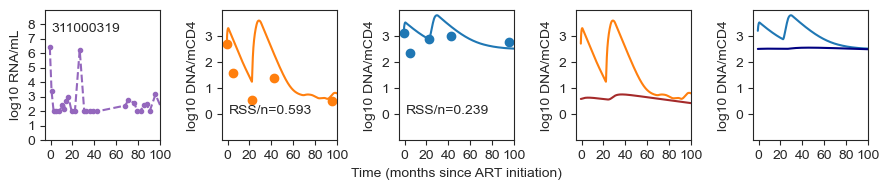

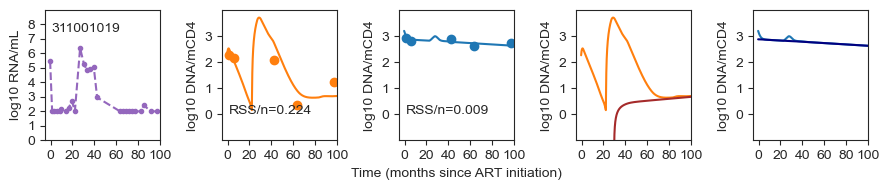

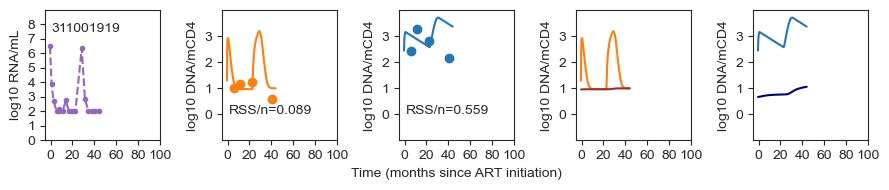

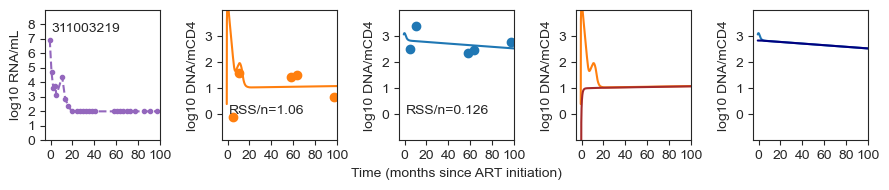

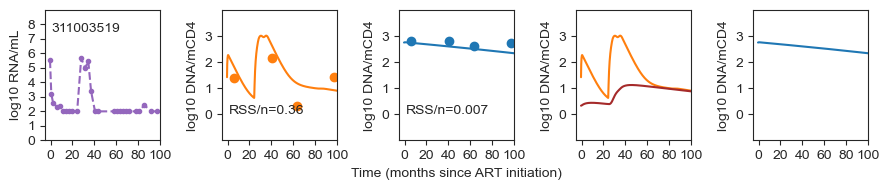

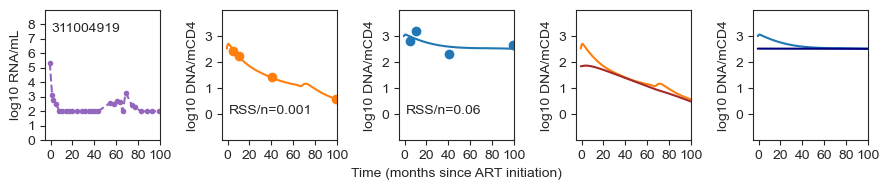

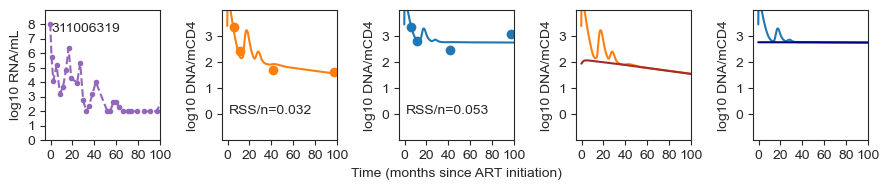

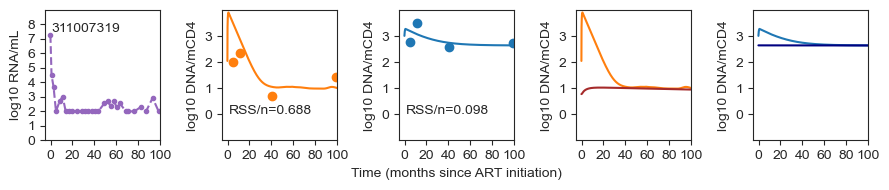

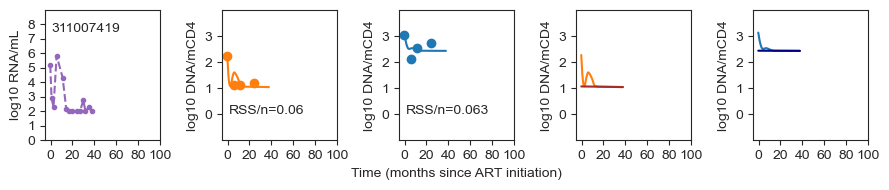

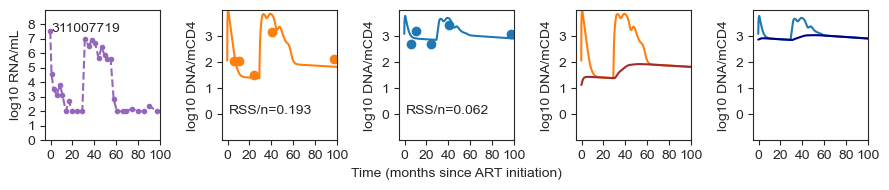

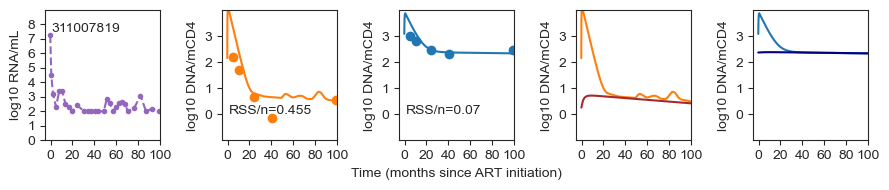

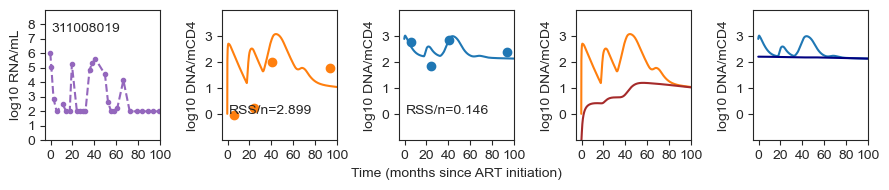

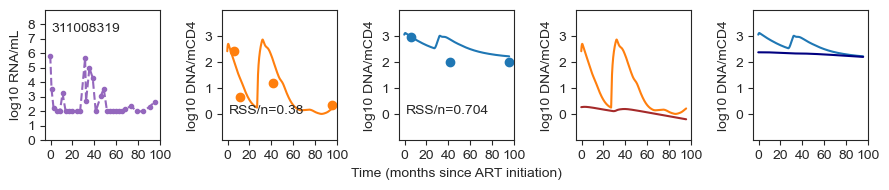

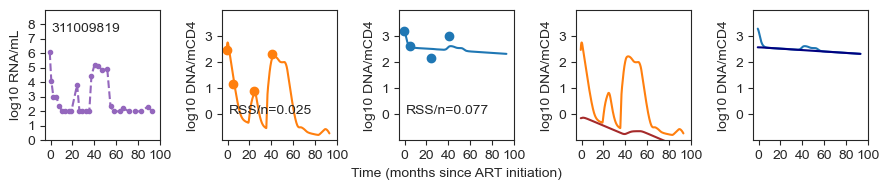

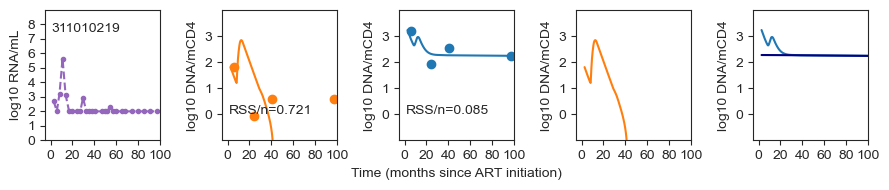

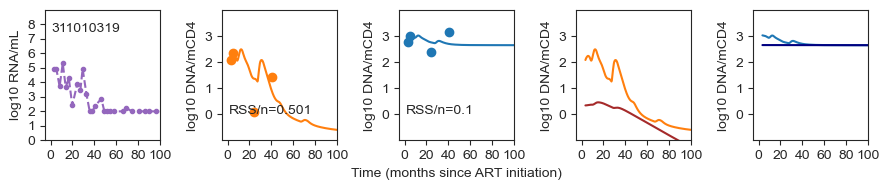

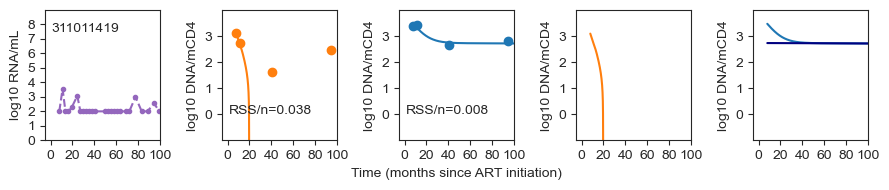

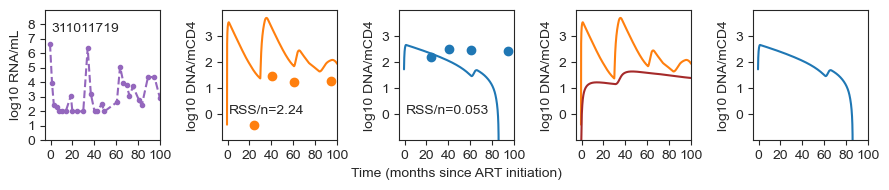

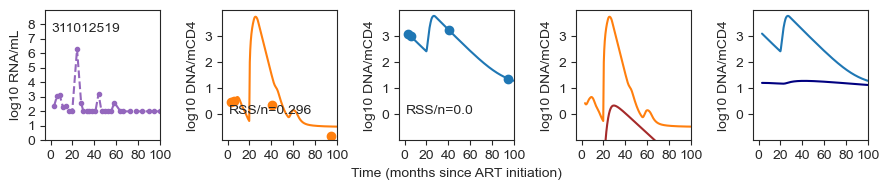

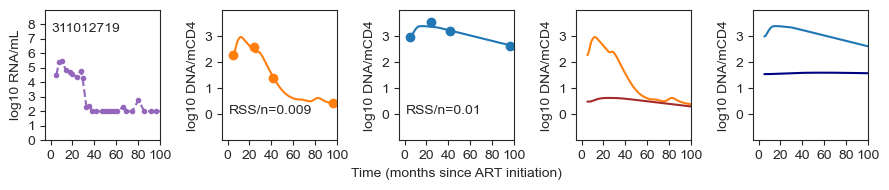

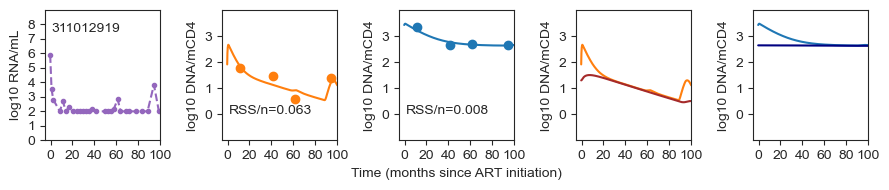

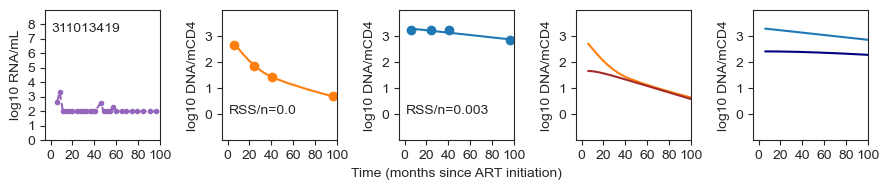

In [8]:
#plot ALL

###### plot of ODE fitting for selected participants in gpl2
for ip,p in enumerate(gpl):
    tdf=df[df['master_ptid']==p]
    tdf2=tdf.dropna()

    tt=tdf['ART_mo'].values #keep in months
    Vt=tdf['log10VL'].values
    t_data_fit = tdf2['ART_mo'].values
    I_data_fit = tdf2['log10int'].values
    D_data_fit = tdf2['log10def'].values

    LOD=np.min(Vt)
    
    czI,czD=['tab:orange','tab:blue']
    
    teval = np.linspace(tt[0],tt[-1],10**4)

    bS,dA,phi,dL,A0 = opt_param[0][ip] #use best param
    solI = get_sol(tt,Vt,teval,bS,dA,phi,dL,A0,phi*A0/dL,LOD,truemin)
    
    bS,dA,phi,dL,A0 = opt_param[1][ip] #use best param
    solD = get_sol(tt,Vt,teval,bS,dA,phi,dL,A0,phi*A0/dL,LOD,truemin)

    plt.figure(figsize=(9,2))

    plt.subplot(151)
    
    Vt[Vt==LOD]=truemin
    plt.plot(tt,Vt,color='tab:purple',marker='.',ls='--')
    plt.ylim([0,9])
    plt.yticks(np.arange(9))
    plt.xlim([-5,100])
    plt.xticks(np.arange(0,101,20))
    plt.annotate(p,[1,7.5])
    plt.ylabel('log10 RNA/mL')

    plt.subplot(152)
    plt.plot(t_data_fit,I_data_fit,marker='o',ls='',color=czI,label='Observed')
    plt.plot(teval,np.log10(solI.y[0]+solI.y[1]),label='Model',ls='-',color=czI)
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.ylabel('log10 DNA/mCD4')
    #plt.legend()
    plt.annotate('RSS/n='+str(np.round(RSSl[0][ip],3)),[1,0])
    plt.xticks(np.arange(0,101,20))
    
    plt.subplot(153)
    plt.plot(t_data_fit,D_data_fit,marker='o',ls='',color=czD,label='Observed')
    plt.plot(teval,np.log10(solD.y[0]+solD.y[1]),label='Model',ls='-',color=czD)
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.ylabel('log10 DNA/mCD4')
    plt.xlabel('Time (months since ART initiation)')
    #plt.legend()
    plt.annotate('RSS/n='+str(np.round(RSSl[1][ip],3)),[1,0])
    plt.xticks(np.arange(0,101,20))

    plt.subplot(154)
    plt.plot(solI.t,np.log10(solI.y[0]+solI.y[1]),label='I2',ls='-',color=czI)
    plt.plot(solI.t,np.log10(solI.y[1]),label='I3',marker='',color='brown')
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.xticks(np.arange(0,101,20))
    plt.ylabel('log10 DNA/mCD4')
    #plt.legend()
    
    plt.subplot(155)
    plt.plot(solD.t,np.log10(solD.y[0]+solD.y[1]),label='D2',ls='-',color=czD)
    plt.plot(solD.t,np.log10(solD.y[1]),label='D3',marker='',color='navy')
    plt.yticks([0,1,2,3])
    plt.ylim([-1,4])
    plt.xlim([-5,100])
    plt.xticks(np.arange(0,101,20))
    plt.ylabel('log10 DNA/mCD4')
    #plt.legend()

    plt.tight_layout()
    plt.savefig('figures/allsplinefits/'+str(p)+'.pdf',dpi=600)
    #plt.close()

/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_81084/3805437246.py:41: RuntimeWarning: invalid value encountered in log10
  axs[1][ip].plot(teval,np.log10(solI.y[1]),label='Model',ls='--',color='brown')
/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_81084/3805437246.py:46: RuntimeWarning: invalid value encountered in log10
  axs[2][ip].plot(teval,np.log10(solD.y[1]),label='Model',ls='--',color='navy')


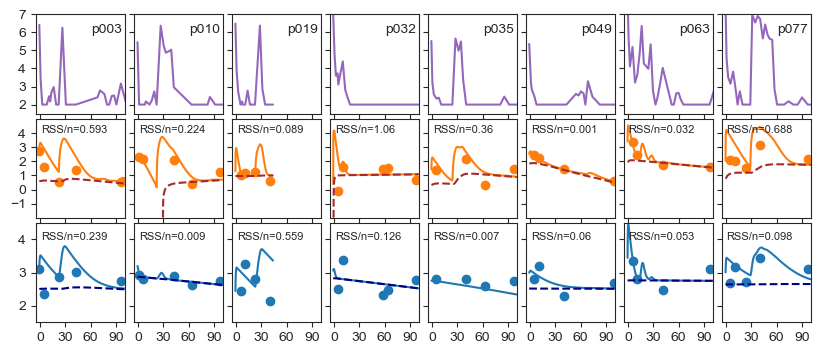

In [9]:
#plot differently...

#plot ALL

###### plot of ODE fitting for selected participants in gpl2
fig,axs = plt.subplots(3,8,sharex=True,sharey='row',figsize=(10,4))

ri=np.random.randint(0,len(gpl),8)
ri=list(np.arange(0,7))+[9]

for ip in range(len(ri)):
    p=gpl[ri[ip]]
    tdf=df[df['master_ptid']==p]
    tdf2=tdf.dropna()

    tt=tdf['ART_mo'].values #keep in months
    Vt=tdf['log10VL'].values
    t_data_fit = tdf2['ART_mo'].values
    I_data_fit = tdf2['log10int'].values
    D_data_fit = tdf2['log10def'].values

    LOD=np.min(Vt)
    
    czI,czD=['tab:orange','tab:blue']
    
    teval = np.linspace(tt[0],tt[-1],10**4)

    bS,dA,phi,dL,A0 = opt_param[0][ip] #use best param
    solI = get_sol(tt,Vt,teval,bS,dA,phi,dL,A0,phi*A0/dL,LOD,truemin)
    
    bS,dA,phi,dL,A0 = opt_param[1][ip] #use best param
    solD = get_sol(tt,Vt,teval,bS,dA,phi,dL,A0,phi*A0/dL,LOD,truemin)

    Vt[Vt==LOD]=truemin
    
    axs[0][ip].plot(tt,Vt,color='tab:purple',marker='',ls='-')
    axs[0][ip].annotate('p'+str(p)[4:7],[60,6],fontsize=10) #311000319

    axs[1][ip].plot(t_data_fit,I_data_fit,marker='o',ls='',color=czI,label='Observed')
    axs[1][ip].plot(teval,np.log10(solI.y[0]+solI.y[1]),label='Model',ls='-',color=czI)
    axs[1][ip].plot(teval,np.log10(solI.y[1]),label='Model',ls='--',color='brown')
    axs[1][ip].annotate('RSS/n='+str(np.round(RSSl[0][ip],3)),[1,4],fontsize=8)
    
    axs[2][ip].plot(t_data_fit,D_data_fit,marker='o',ls='',color=czD,label='Observed')
    axs[2][ip].plot(teval,np.log10(solD.y[0]+solD.y[1]),label='Model',ls='-',color=czD)
    axs[2][ip].plot(teval,np.log10(solD.y[1]),label='Model',ls='--',color='navy')
    axs[2][ip].annotate('RSS/n='+str(np.round(RSSl[1][ip],3)),[1,4],fontsize=8)

axs[0][ip].set_yticks(np.arange(9))
axs[0][ip].set_ylim([1.5,7])
axs[0][ip].set_xlim([-5,100])
axs[0][ip].set_xticks(np.arange(0,96,30))

axs[1][ip].set_yticks([-1,0,1,2,3,4])
axs[1][ip].set_ylim([-2,5])

axs[2][ip].set_yticks([1,2,3,4])
axs[2][ip].set_ylim([1.5,4.5])

fig.subplots_adjust(hspace=0.05,wspace=0.1)
fig.savefig('figures/splinefitexamples.svg')#,dpi=600)


In [10]:
#merge the files into 1 giant pdf

#treated first
fns = os.listdir('figures/allsplinefits/')
#fns.remove('.DS_Store')
fns.sort()

# Call the PdfFileMerger
mergedObject = PdfFileMerger()

# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for fn in fns:
    mergedObject.append(PdfFileReader('figures/allsplinefits/'+fn, 'rb'))

# Write all the files into a file which is named as shown below
mergedObject.write('../paper/SupplementaryData1-mergedfits.pdf')


In [11]:
len(gpl)

22

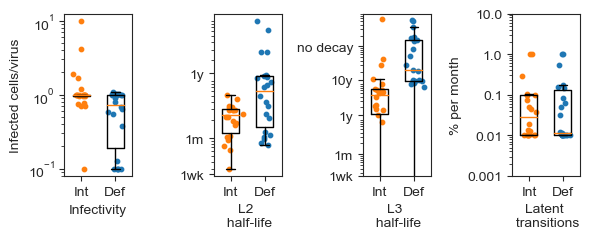

In [12]:
#show parameter values
jit=0.1

czi='tab:orange'
czd='tab:blue'

opI=np.array(opt_param[0]); opD=np.array(opt_param[1])

plt.figure(figsize=(6,2.5))
plt.subplot(141)
plt.boxplot([opI[:,0],opD[:,0]],widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(opI)),opI[:,0],c=czi,s=10)
plt.scatter(np.random.normal(2,jit,len(opD)),opD[:,0],c=czd,s=10)
plt.semilogy()
plt.xticks([1,2],['Int','Def'])
plt.xlabel('Infectivity')
plt.ylabel('Infected cells/virus')

plt.subplot(142)
plt.boxplot([np.log(2)/opI[:,1],np.log(2)/opD[:,1]],widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(opI)),np.log(2)/opI[:,1],c=czi,s=10)
plt.scatter(np.random.normal(2,jit,len(opD)),np.log(2)/opD[:,1],c=czd,s=10)
plt.semilogy()
plt.xlabel('L2 \n half-life')
plt.xticks([1,2],['Int','Def'])
#plt.ylabel('Months')
plt.yticks([1/4,1,12],['1wk','1m','1y'])

plt.subplot(143)
plt.boxplot([np.log(2)/opI[:,3],np.log(2)/opD[:,3]],widths=0.5,showfliers=False)

#set "max"
#opI[np.log(2)/opI[:,3]>240,3]=240
#opI[np.log(2)/opI[:,3]>240,3]=240

plt.scatter(np.random.normal(1,jit,len(opI)),np.log(2)/opI[:,3],c=czi,s=10)
plt.scatter(np.random.normal(2,jit,len(opD)),np.log(2)/opD[:,3],c=czd,s=10)
plt.semilogy()
plt.xticks([1,2],['Int','Def'])
plt.xlabel('L3 \n half-life')
#plt.ylabel('Months')
plt.yticks([1/4,1,12,120,1000],['1wk','1m','1y','10y','no decay'])

plt.subplot(144)
plt.boxplot([opI[:,2]*100,opD[:,2]*100],widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(opI)),opI[:,2]*100,c=czi,s=10)
plt.scatter(np.random.normal(2,jit,len(opD)),opD[:,2]*100,c=czd,s=10)
plt.semilogy()
plt.xlabel('Latent \n transitions')
plt.xticks([1,2],['Int','Def'])
plt.ylabel('% per month')
plt.yticks(np.logspace(-3,1,5),np.logspace(-3,1,5))
    
plt.tight_layout()
plt.savefig('figures/splinemodel-params.svg',dpi=600)

MannwhitneyuResult(statistic=438.0, pvalue=0.21143514553484177)
MannwhitneyuResult(statistic=433.0, pvalue=0.18958780084207516)
MannwhitneyuResult(statistic=413.0, pvalue=0.0010887862676337166)
MannwhitneyuResult(statistic=504.0, pvalue=5.978287764517014e-09)


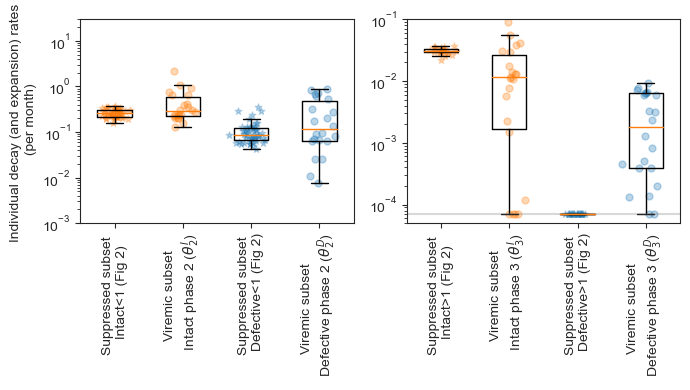

In [23]:
#compare with estimates from suppressed cohort
#TRUNCATED

pdf = pd.read_csv('data/rates_monolix_indiv.csv')

plt.figure(figsize=(7,4))
jit=0.1
sz=25
az=0.3

plt.subplot(121)

plt.boxplot([pdf['Intact<1'].dropna(),opI[:,1],pdf['Defective<1'].dropna(),opD[:,1],],widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(pdf['Intact<1'].dropna())),pdf['Intact<1'].dropna(),c=czi,s=sz,marker='*',alpha=az)
plt.scatter(np.random.normal(2,jit,len(opI)),opI[:,1],c=czi,s=sz,alpha=az)
plt.scatter(np.random.normal(3,jit,len(pdf['Defective<1'].dropna())),pdf['Defective<1'].dropna(),c=czd,s=sz,marker='*',alpha=az)
plt.scatter(np.random.normal(4,jit,len(opD)),opD[:,1],c=czd,s=sz,alpha=az)

plt.xticks([1,2,3,4],['Suppressed subset \n Intact<1 (Fig 2)','Viremic subset \n Intact phase 2'+r' ($\theta_2^I$)',
                      'Suppressed subset \n Defective<1 (Fig 2)','Viremic subset \n Defective phase 2'+r' ($\theta_2^D$)',],rotation=90)

print(st.mannwhitneyu(pdf['Intact<1'].dropna(),opI[:,1]))
print(st.mannwhitneyu(pdf['Defective<1'].dropna(),opD[:,1]))

plt.semilogy()
plt.ylim([1e-3,30])
plt.ylabel('Individual decay (and expansion) rates \n (per month)')

plt.subplot(122)

truncIsup=pdf['Intact>1'].dropna().values
truncIsup[truncIsup<0]=np.log(2)/1e4

truncDsup=pdf['Defective>1'].dropna().values
truncDsup[truncDsup<0]=np.log(2)/1e4

truncIvir=opI[:,3].copy()
truncIvir[truncIvir<0]=np.log(2)/1e4

truncDvir=opD[:,3].copy()
truncDvir[truncDvir<0]=np.log(2)/1e4

plt.boxplot([truncIsup,truncIvir,truncDsup,truncDvir],widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(truncIsup)),truncIsup,c=czi,s=sz,marker='*',alpha=az)
plt.scatter(np.random.normal(2,jit,len(truncIvir)),truncIvir,c=czi,s=sz,alpha=az)
plt.scatter(np.random.normal(3,jit,len(truncDsup)),truncDsup,c=czd,s=sz,marker='*',alpha=az)
plt.scatter(np.random.normal(4,jit,len(truncDvir)),truncDvir,c=czd,s=sz,alpha=az)

plt.xticks([1,2,3,4],['Suppressed subset \n Intact>1 (Fig 2)','Viremic subset \n Intact phase 3'+r' ($\theta_3^I$)',
                      'Suppressed subset \n Defective>1 (Fig 2)','Viremic subset \n Defective phase 3'+r' ($\theta_3^D$)',],rotation=90)
plt.axhline(np.log(2)/1e4,color='gray',alpha=0.3)
plt.ylim([5e-5,1e-1])
plt.semilogy()

print(st.mannwhitneyu(truncIsup,truncIvir))
print(st.mannwhitneyu(truncDvir,truncDsup))

plt.tight_layout()
plt.savefig('figures/splinemodel-decaycompare2.svg',dpi=600)

In [ ]:
#correalte bI and bD?

plt.figure(figsize=(3,2))
sns.regplot(np.log10(opI)[:,0],np.log10(opD)[:,0])
#plt.scatter(np.array(opt_param)[:,0],np.array(opt_param_def)[:,0])
#plt.loglog()
plt.xlabel('Intact creation rate')
plt.ylabel('Defective creation rate')

In [ ]:
#ratio, fraction intact

brat = np.log10(opI[:,0]/(opI[:,0]+opD[:,0]))

plt.figure(figsize=(2,3))
plt.boxplot(brat,widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(brat)),brat,c='tab:red',s=10)
#plt.semilogy()
plt.yticks([-3,np.log10(1/500),np.log10(1/200),-2,np.log10(1/50),np.log10(1/20),-1,np.log10(1/5),np.log10(1/2),0,],['1:1000','1:500','1:200','1:100','1:50','1:20','1:10','1:5','1:2','1:1'])

plt.xticks([1],['% of infected cells intact'])
plt.tight_layout()
plt.savefig('figures/splinemodel-params-%int.pdf',dpi=600)

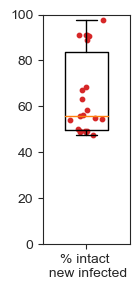

In [17]:
#ratio, fraction intact

brat = opI[:,0]/(opI[:,0]+opD[:,0])*100

plt.figure(figsize=(1.5,3))
plt.boxplot(brat,widths=0.5,showfliers=False)
plt.scatter(np.random.normal(1,jit,len(brat)),brat,c='tab:red',s=10)

plt.xticks([1],['% intact \n new infected'])
plt.ylim([0,100])
plt.tight_layout()
plt.savefig('figures/splinemodel-params-%int.svg',dpi=600)

In [32]:
print(np.min(brat),np.max(brat))

10.201119587615812 91.6235702430151
